<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-3.-Patient-Drug-Review" data-toc-modified-id="Case-3.-Patient-Drug-Review-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 3. Patient Drug Review</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Models-and-training" data-toc-modified-id="Models-and-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models and training</a></span></li><li><span><a href="#Results-and-Discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Discussion</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Case 3. Patient Drug Review
Oliver Andersson<br>
Hannu Korhonen<br>
Juho Oksa<br><br>
Team 3<br><br>
Last edited: 19.03.2020<br><br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

# Background

In this exercise, we make a neural network that tries to guess what score a user gave for a drug, based on a written review, using sentiment analysis.

# Data

The dataset is a database containing reviews for drugs with both a written review and a rating. The data also contains a unique ID, name of the drug, what condition the drug was used for, date of the review, and how many users found the review helpful.

In [2]:
%pylab inline
import time # for timing
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split # preprocessing datasets
from tensorflow.keras.preprocessing.text import Tokenizer # text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences # text preprocessing

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Creating the dataframe for training
train = pd.read_csv('drugsComTrain_raw.csv')

# Show the first 5 rows of the train set
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
%%time
# turn the text into tokens
samples = train['review']
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)

# Convert the tokens into sequences
sequences = tokenizer.texts_to_sequences(samples)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 51429 unique tokens.
Wall time: 11.9 s


In [5]:
#pad or cut the sequences so they are the same lenght
data = pad_sequences(sequences, maxlen=200)

In [6]:
%%time
#Split the ratings into 3 categories, >6 is positive, 5 and 6 is neutral and <5 is negative
labels = train['rating'].values
for i in range(len(labels)):
    x = labels[i]
    if x > 6:
        labels[i] = 2
    elif x >= 5:
        labels[i] = 1
    else:
        labels[i] = 0

Wall time: 74.8 ms


In [7]:
from tensorflow.keras.utils import to_categorical

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (161297, 200)
Shape of label tensor: (161297, 3)


In [8]:
VALIDATION_SPLIT = 0.25

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

# Models and training

In [9]:
# Import needed models and layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, SimpleRNN, Dropout, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding # layers for neural networks
from tensorflow.keras.initializers import Constant
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score # final metrics
from tensorflow.keras import regularizers

### Model 1

For the first model, we try a simple recurrent neural network.

In [10]:
model = Sequential()
model.add(Embedding(5000, 36))
model.add(SimpleRNN(36, kernel_regularizer=regularizers.l2(0.1),))
model.add(Dropout(0.12))
model.add(Dense(3, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 36)          180000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 36)                2628      
_________________________________________________________________
dropout (Dropout)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 111       
Total params: 182,739
Trainable params: 182,739
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

In [12]:
%%time
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          verbose=0,
          validation_data=(x_val, y_val))

Wall time: 22min 11s


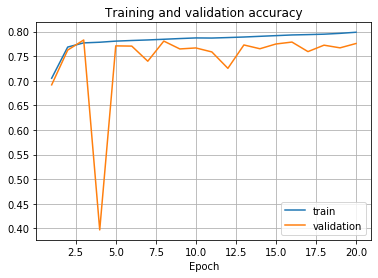

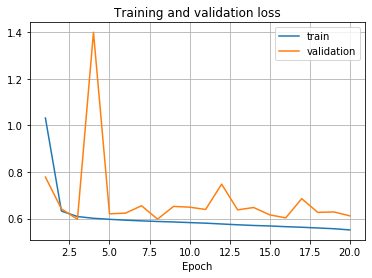

In [13]:
# Plot the accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
e = arange(len(acc)) + 1

plot(e, acc, label = 'train')
plot(e, val_acc, label = 'validation')
title('Training and validation accuracy')
xlabel('Epoch')
grid()
legend()

figure()

plot(e, loss, label = 'train')
plot(e, val_loss, label = 'validation')
title('Training and validation loss')
xlabel('Epoch')
grid()
legend()

show()

The accuracy isn't too great but it validates well and is relatively quick to train.

### Model 2

For the second model we try a 1D convolutional neural network.

In [16]:
embedding_layer = Embedding(5000,
                            100,
                            input_length=200,
                            trainable=True)

sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)


x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l1(0.01))(x)
preds = Dense(3, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          500000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 65, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 61, 128)           82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 128)           8204

In [17]:
%%time
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=0,
          validation_data=(x_val, y_val))

Wall time: 42min 25s


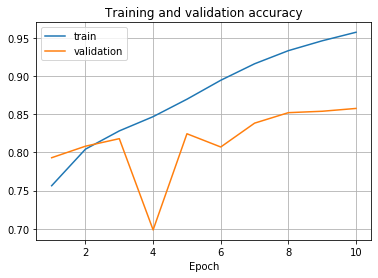

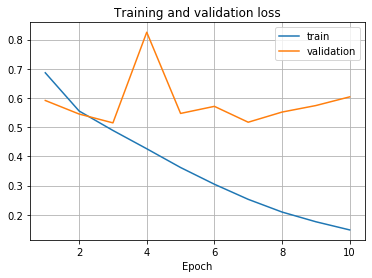

In [18]:
# Plot the accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
e = arange(len(acc)) + 1

plot(e, acc, label = 'train')
plot(e, val_acc, label = 'validation')
title('Training and validation accuracy')
xlabel('Epoch')
grid()
legend()

figure()

plot(e, loss, label = 'train')
plot(e, val_loss, label = 'validation')
title('Training and validation loss')
xlabel('Epoch')
grid()
legend()

show()

The model seems to overfit a bit, but the validation accuracy is still better than the first model.

### Model 3

for the third model we tried to use a simple recurrent neural network with an extra dense layer before the output layer.

In [19]:
model = Sequential()
model.add(Embedding(5000, 30))
model.add(SimpleRNN(30, kernel_regularizer=regularizers.l2(0.1),))
model.add(Dropout(0.12))
model.add(Dense(48, activation = 'relu'))
model.add(Dropout(0.12))
model.add(Dense(3, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 30)          150000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 30)                1830      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 48)                1488      
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 147       
Total params: 153,465
Trainable params: 153,465
Non-trainable params: 0
________________________________________________

In [20]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

In [21]:
%%time
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          verbose=0,
          validation_data=(x_val, y_val))

Wall time: 27min 39s


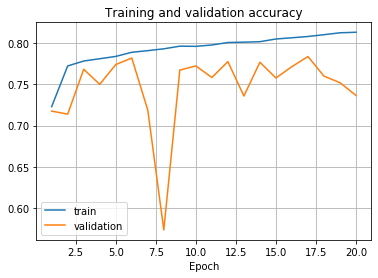

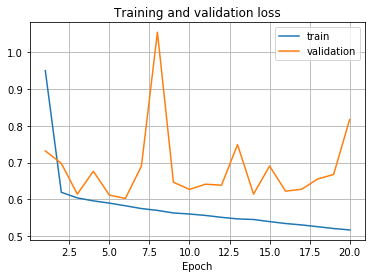

In [22]:
# Plot the accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
e = arange(len(acc)) + 1

plot(e, acc, label = 'train')
plot(e, val_acc, label = 'validation')
title('Training and validation accuracy')
xlabel('Epoch')
grid()
legend()

figure()

plot(e, loss, label = 'train')
plot(e, val_loss, label = 'validation')
title('Training and validation loss')
xlabel('Epoch')
grid()
legend()

show()

This model performed the worst.

# Results and Discussion

We went with the second model as our winning horse.

In [23]:
embedding_layer = Embedding(5000,
                            100,
                            input_length=200,
                            trainable=True)

sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)


x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l1(0.01))(x)
preds = Dense(3, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 100)          500000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 65, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 61, 128)           82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 16, 128)           8204

In [24]:
%%time
#we train the model with all the training data without validation
history = model.fit(data, labels,
          batch_size=128,
          epochs=10,
          verbose=0)

Wall time: 52min 19s


Here we preprocess the test data in a similar way we processed the training data.

In [65]:
test = pd.read_csv('drugsComTest_raw.csv')

In [66]:
test_samples = test['review']
test_labels = test['rating'].values
test_sequences = tokenizer.texts_to_sequences(test_samples)
test_data = pad_sequences(test_sequences, maxlen=200)
print('Shape of label tensor:', test_labels.shape)

Shape of label tensor: (53766,)


In [67]:
for i in range(len(test_labels)):
    x = test_labels[i]
    if x > 6:
        test_labels[i] = 2
    elif x >= 5:
        test_labels[i] = 1
    else:
        test_labels[i] = 0

In [76]:
#Use the model to make predictions of the test reviews
predicted = argmax(model.predict(test_data), axis = 1)

In [82]:
# Calculate the classification report
cr = classification_report(test_labels, predicted)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.74      0.81     13497
           1       0.46      0.70      0.56      4829
           2       0.94      0.94      0.94     35440

    accuracy                           0.87     53766
   macro avg       0.77      0.79      0.77     53766
weighted avg       0.89      0.87      0.87     53766



In the classification report, we can see that the model perfomed on on average accuracy of 87% which is okay and the model is better at predicting positive reviews than neutral or negative.

In [83]:
# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predicted).T
print(cm)

[[ 9947   405   592]
 [ 2310  3386  1666]
 [ 1240  1038 33182]]


In [84]:
k = cohen_kappa_score(test_labels, predicted)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(test_labels, predicted, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.731
Cohen's kappa (quadratic) = 0.831


# Conclusions

Comparing our results to <a href='http://kdd.cs.ksu.edu/Publications/Student/kallumadi2018aspect.pdf'>Grässer et al (2018) article</a>, Our model performed worse than their sentiment analysis model. accuracy of 87% vs 92% and Cohen's kappa of 83% vs  84%

All three models were showing a growing trend however, so it is possible some of them might have surpassed the sentiment analysis model given enough epochs. sadly, due to time constraints we cannot test this.

We learned that making a neural network for predicting outcomes from text are considerably more difficult than more simple numeric or image predictions.